In [1]:
# imports 

from pathlib import Path
from typing import Union

import os
import pickle 
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import copy
from torchvision import transforms
from torchvision.datasets import ImageFolder

import torch
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import csv
import random
import numpy as np
from PIL import Image 
from tqdm import tqdm

import sys
sys.path.append(r'/home/afroehli/coding/util_scripts')
from utils_dataloading.dassl_datum_mod import DatumWithWnid 
from utils_dataloading.imagenet_tree import ImagenetSemanticInfo, ImagenetSemanticSubtree

sys.path.append(r'/home/afroehli/coding/OOD-X-Benchmarks')
from datasets import imagenet_x as i_x, imagenet_r_x as r_x, imagenet_c_x as c_x, imagenet_v2_x as v2_x

# other setup
random.seed(3)

In [2]:

# load model 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device used: {device}')

dinov2_vits14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')
dinov2_vits14.eval()
dinov2_vits14.to(device)

transform = transforms.Compose([transforms.Resize((154, 210)),
                                transforms.ToTensor()])


# load semantic-info object
with open(r'/home/afroehli/coding/pickle_data/imagenet_semantic_info.pkl', 'rb') as pkl_file:
    semantic_info = pickle.load(pkl_file)


# load classes that are common in all imagenet variances 
wnids_common_classes = set()
with open('/home/afroehli/coding/dinov2_ood/storage/union_set_classes.txt', 'r') as union_file: 
    for line in union_file.readlines():
        common_wnid = line.rstrip('\n')
        wnids_common_classes.add(common_wnid)


# defined empty datasets_dict-structure
datasets_dict = {
        'imagenet_x': {'filename': 'imagenet_x_val_results.pkl', 'sorted_classes': None, 'model_results' : None},
        'imagenet_x_train': {'filename': 'imagenet_x_train_results.pkl', 'sorted_classes': None, 'model_results' : None}, 
        'imagenet_r': {'filename': 'imagenet_r_results.pkl', 'sorted_classes': None, 'model_results': None}, 
        'imagenet_v2': {'filename': 'imagenet_v2_results.pkl', 'sorted_classes': None, 'model_results': None}, 
        'imagenet_c': {'filename': 'imagenet_c_results.pkl', 'sorted_classes': None, 'model_results': None}
}

# overwritten with already filled dictionary
with open('/home/afroehli/coding/pickle_data/dinov2_ood_datasets_dict.pkl', 'rb') as pickle_file:
    datasets_dict = pickle.load(pickle_file)


# for dataset_name in datasets_dict.keys():
#     try:
#         if datasets_dict[dataset_name]['sorted_classes'] == None:
#             print(f'Try to load dataset: {dataset_name}')
#             with open(f'/home/afroehli/coding/pickle_data/dataset_objects/{dataset_name}_sorted.pkl', 'rb') as pickle_file: 
#                 datasets_dict[dataset_name]['sorted_classes'] = pickle.load(pickle_file)
#     except FileNotFoundError:
#         print(f'Dataset-file was not found: {dataset_name}_sorted.pkl')
#         datasets_dict[dataset_name]['sorted_classes'] = None

#     try:
#         if datasets_dict[dataset_name]['model_results'] == None:
#             print(f'Try to load model-results for: {dataset_name}')
#             model_results_fname = f'/home/afroehli/coding/pickle_data/model_output/{datasets_dict[dataset_name]['filename']}'
#             with open(model_results_fname, 'rb') as pickle_file:
#                 datasets_dict[dataset_name]['model_results'] = pickle.load(pickle_file)
#     except FileNotFoundError: 
#         print(f'Model-results file could not be found: {model_results_fname}')
#         datasets_dict[dataset_name]['model_results'] = None



model_res_loaded = [dset for dset in datasets_dict.keys() if datasets_dict[dset]['model_results'] !=  None]
model_res_not_loaded = [dset for dset in datasets_dict.keys() if datasets_dict[dset]['model_results'] ==  None]

print(f'Following datasets were loaded: {model_res_loaded}')
print(f'Following datasets are missing: {model_res_not_loaded}')

Device used: cuda


Using cache found in /home/afroehli/.cache/torch/hub/facebookresearch_dinov2_main
/home/afroehli/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/afroehli/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/afroehli/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


Following datasets were loaded: ['imagenet_x', 'imagenet_r', 'imagenet_v2', 'imagenet_c', 'imagenet_x_train', 'imagenet_c_new_zoom_sev_1', 'imagenet_c_new_zoom_sev_5']
Following datasets are missing: []


In [6]:

base_pth = '/home/afroehli/coding/model_results/dinov2_vits14'

for dset_name in ['imagenet_c_new_zoom_sev_1', 'imagenet_c_new_zoom_sev_5']:
    
    if dset_name == 'imagenet_x':
        store_name = 'imagenet_1k_val'
    elif dset_name == 'imagenet_x_train':
        store_name = 'imagenet_1k_train'
    else:
        store_name = dset_name 

    if dset_name != 'imagenet_c_new_zoom_sev_1' and dset_name != 'imagenet_c_new_zoom_sev_5':
        with open(f'/home/afroehli/coding/model_results/dinov2_vits14/{store_name}.pkl', 'wb') as pkl_file:
            pickle.dump(datasets_dict[dset_name]['model_results'], pkl_file, pickle.HIGHEST_PROTOCOL)
    else: 
        if dset_name == 'imagenet_c_new_zoom_sev_1': 
            with open('/home/afroehli/coding/model_results/dinov2_vits14/imagenet_c_orig/sev_1/imagenet_c_orig_zoom_1.pkl', 'wb') as pkl_file: 
                pickle.dump(datasets_dict[dset_name]['model_results'], pkl_file, pickle.HIGHEST_PROTOCOL)
        elif dset_name == 'imagenet_c_new_zoom_sev_5': 
            with open('/home/afroehli/coding/model_results/dinov2_vits14/imagenet_c_orig/sev_5/imagenet_c_orig_zoom_5.pkl', 'wb') as pkl_file: 
                pickle.dump(datasets_dict[dset_name]['model_results'], pkl_file, pickle.HIGHEST_PROTOCOL)
        else:
            raise ValueError(f'Dset-name {dset_name} has no point to be stored')

In [ ]:
 # for each common-class, find closest class in rest of imagenet-1k (999 candidates)

common_class_comparisons = dict()
imagenet_wnids = list(imagenet_x_val_results.keys())

print(f'Number of detected common-wnids: {len(wnids_common_classes)}')
print(f'Number of detected imagenet-wnids: {len(imagenet_wnids)}')

for common_wnid in wnids_common_classes:

    # calculate mean of model-output for this class 
    ood_mean = np.mean(imagenet_x_val_results[common_wnid], axis=0)

    imagenet_wnids.remove(common_wnid)
    for class_wnid in imagenet_wnids: 

        # calculate mean of selected class
        class_mean = np.mean(imagenet_x_val_results[class_wnid], axis=0)
        diff_ood = np.abs(ood_mean - class_mean)
        sum_class_diff = np.sum(diff_ood)
        try:
            common_class_comparisons[common_wnid].append((sum_class_diff, class_wnid))
        except KeyError:
            common_class_comparisons[common_wnid] = [(sum_class_diff, class_wnid)]

    # sort calculated mean differences
    common_class_comparisons[common_wnid].sort(key = lambda ood_id: ood_id[0])
    imagenet_wnids.append(common_wnid)

Number of detected common-wnids: 135
Number of detected imagenet-wnids: 1000


In [ ]:
# control output of closest classes 

for n, common_wnid in enumerate(common_class_comparisons.keys()):

    top_three = common_class_comparisons[common_wnid][:3]
    top_three_names = [(semantic_info.wnid_to_classname[tt_wnid], tt_score) for tt_score, tt_wnid in top_three]
    print(f'{n}: CC-Class = {semantic_info.wnid_to_classname[common_wnid]}, Next classes = {top_three_names}')

In [ ]:
# store class split 

with open('/home/afroehli/coding/dinov2_ood/storage/class_split.csv', 'w', newline='') as class_split_table:
    split_writer = csv.writer(class_split_table, delimiter=';')

    for common_wnid in common_class_comparisons.keys():
        closest_class_wnid = common_class_comparisons[common_wnid][0][1]
        split_writer.writerow([common_wnid, closest_class_wnid])


In [3]:
# load class pairs 

closest_classes = [] 
    

with open('/home/afroehli/coding/dinov2_ood/storage/class_split.csv', 'r')as class_split_table:
    split_reader = csv.reader(class_split_table, delimiter=';')
    for n, table_row in enumerate(split_reader):
        class_1 = table_row[0]
        class_2 = table_row[1]
        new_combination = (class_1, class_2)
        closest_classes.append(new_combination)



In [12]:
# util functions  

def get_random_class() -> str:
    all_classes = list(datasets_dict['imagenet_x']['sorted_classes'].keys())
    n_classes = len(all_classes)
    next_int = random.randint(0, n_classes - 1)
    next_class = all_classes[next_int]

    return next_class

In [ ]:
# RECREATION could cause a new order of directories
# order of directoies used to encode class of batch-item 

# with open('/home/afroehli/coding/dinov2_ood/storage/imagenet_train_class_to_index_mapping.csv', 'w', newline='') as class_index_table: 
#     class_index_writer = csv.writer(class_index_table, delimiter=';')

#     imagenet_classes_wnids = os.listdir('/home/afroehli/coding/OOD-X-Benchmarks/data/imagenet/images/train')

#     for n, wnid in enumerate(imagenet_classes_wnids):
#         class_index_writer.writerow([wnid, n])

In [4]:
# list for mapping indexes to wnids
imagenet_class_list = []
with open('/home/afroehli/coding/dinov2_ood/storage/imagenet_train_class_to_index_mapping.csv', 'r') as class_index_table:
    class_index_reader = csv.reader(class_index_table, delimiter=';')
    for table_row in class_index_reader:
        imagenet_class_list.append(table_row[0])


In [5]:
# Dataset where classes are defined by directories + exclude directories from loading by instantiation 

class CustomizedImageFolder(ImageFolder): 

    def __init__(self, not_processed_imagenet_classes = None, root = None, transform = None):
        self.not_processed_imagenet_classes = not_processed_imagenet_classes 
        super().__init__(root = root, transform = transform)

    def find_classes(self, directory: Union[str, Path]) -> tuple[list[str], dict[str, int]]:

        class_list = []
        class_index_dict = dict()
    
        with open('/home/afroehli/coding/dinov2_ood/storage/imagenet_train_class_to_index_mapping.csv', 'r') as class_index_table:

            class_index_reader = csv.reader(class_index_table, delimiter=';')
            for table_row in class_index_reader:
                class_wnid = table_row[0]
                class_index = table_row[1]

                if class_wnid in self.not_processed_imagenet_classes:
                    class_list.append(class_wnid)
                    class_index_dict[class_wnid] = class_index

        return class_list, class_index_dict

In [7]:
# Create Dataset and DataLoader for all Imagenet-Train classes, that are not covered in the old dump 

all_inet_wnids = list(datasets_dict['imagenet_x']['sorted_classes'].keys())
print(f'Len all wnids: {len(all_inet_wnids)}')

inet_c_new_zoom_sev_1 = CustomizedImageFolder(not_processed_imagenet_classes = all_inet_wnids, 
                                              root = '/home/afroehli/data/ImagenetC/zoom_blur/1', transform=transform)
inet_c_new_zoom_sev_5 = CustomizedImageFolder(not_processed_imagenet_classes = all_inet_wnids,
                                              root = '/home/afroehli/data/ImagenetC/zoom_blur/5', transform=transform)

inet_c_new_zoom_1_loader = DataLoader(inet_c_new_zoom_sev_1, batch_size=128, shuffle=False, num_workers=8, pin_memory=True)
inet_c_new_zoom_5_loader = DataLoader(inet_c_new_zoom_sev_5, batch_size=128, shuffle=False, num_workers=8, pin_memory=True)

print(f'Dataset-size: {len(inet_c_new_zoom_sev_1)}, {len(inet_c_new_zoom_sev_5)}')
print(f'Dataloader-size: {len(inet_c_new_zoom_1_loader)}, {len(inet_c_new_zoom_5_loader)}')


Len all wnids: 1000
Dataset-size: 50000, 50000
Dataloader-size: 391, 391


296
Wnid is: n01532829


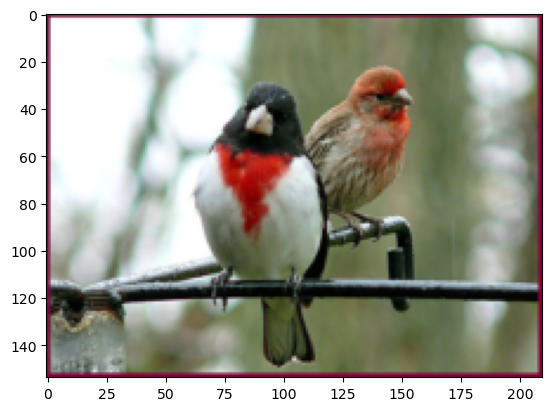

In [ ]:
# Example output from Dataset

data_index = 2600
print(imagenet_train_dataset[data_index][1])
print(f'Wnid is: {imagenet_class_list[int(imagenet_train_dataset[data_index][1])]}')

img_tensor = imagenet_train_dataset[data_index][0].detach().numpy()
img_array = np.squeeze(img_tensor)
img_array = np.transpose(img_array, (1, 2, 0))
plt.imshow(img_array)
plt.show()

In [8]:
# calculate embedding for new classes 

import time 

compare_classes_new_res = dict()
n_batches_per_class = dict()

new_datasets = ['imagenet_c_new_zoom_sev_1', 'imagenet_c_new_zoom_sev_5']

for dataset_name in new_datasets:
        
    if dataset_name == 'imagenet_c_new_zoom_sev_1':
        data_loader = inet_c_new_zoom_1_loader 
    else:
        data_loader = inet_c_new_zoom_5_loader 

    model_results = dict()

    print(f'Next calculate results for dataset: {dataset_name}')

    finished_classes = 0
    batch_process_times = []

    for batch in (pbar := tqdm(data_loader, ncols=100)):

        start_batch_process = time.perf_counter()

        batch_transferred = batch[0].to(device)
        model_out = dinov2_vits14(batch_transferred)

        wnid_per_batch_item = [imagenet_class_list[int(batch_item_index)] for batch_item_index in batch[1]]

        model_out_converted = [batch_item.cpu().detach().numpy() for batch_item in model_out]

        for n, processed_batch_item in enumerate(model_out_converted):
            batch_item_wnid = wnid_per_batch_item[n]
            try: 
                model_results[batch_item_wnid].append(processed_batch_item)
            except KeyError:
                model_results[batch_item_wnid] = []
                model_results[batch_item_wnid].append(processed_batch_item)
                
        end_batch_process = time.perf_counter()
        batch_process_times.append(end_batch_process - start_batch_process)

                # store results for a class if all instances of this class have been processed
                # for wnid in wnids_batch: 
                     
                #      if len(model_results[wnid]) == expected_instances_per_class[wnid]:
                #         with open('/home/afroehli/coding/dinov2_ood/storage/imagenet_x_train_results_dump.pkl', 'wb') as pickle_file: 
                #             pickle.dump(model_results, pickle_file, pickle.HIGHEST_PROTOCOL)

                #         already_processed_wnids.add(wnid)
                #         with open('/home/afroehli/coding/dinov2_ood/storage/imagenet_x_train_processed_classes.pkl', 'wb') as pickle_file:
                #             pickle.dump(already_processed_wnids, pickle_file, pickle.HIGHEST_PROTOCOL)
                        
                #         finished_classes += 1
                #         if finished_classes % 5 == 0:
                #             avg_process_time = sum(batch_process_times) / len(batch_process_times)
                #             print(f'Average batch process time: {avg_process_time}')

            # assign temporary model-result storage to general result dictionary
            # datasets_dict[dataset_name]['model_results'] = model_results 

    datasets_dict[dataset_name] = dict()
    datasets_dict[dataset_name]['model_results'] = model_results


Next calculate results for dataset: imagenet_c_new_zoom_sev_1


100%|█████████████████████████████████████████████████████████████| 391/391 [00:49<00:00,  7.95it/s]


Next calculate results for dataset: imagenet_c_new_zoom_sev_5


100%|█████████████████████████████████████████████████████████████| 391/391 [00:47<00:00,  8.31it/s]


In [10]:
with open('/home/afroehli/coding/pickle_data/dinov2_ood_datasets_dict.pkl', 'wb') as pickle_file:
    pickle.dump(datasets_dict, pickle_file, pickle.HIGHEST_PROTOCOL)

In [7]:
# DataSet for training LinearClassifier
# custom dataset: dictonary -> [(embedding, index_as_tensor)]

class DictionaryDataset(torch.utils.data.Dataset): 
    
    """
    Pararms:
    1) data: complete dataset provided as dict
    2) index_list: list of data_dict-keys, order of keys in list will be used to create a tensor as the expected model-output
    """

    def __init__(self, data: dict, index_list: list[str]): 
        self.data_dict = data
        self.index_list = index_list 
        self.wnid_list = list(self.data_dict.keys())
        self.wnid_iterator = iter(self.wnid_list)
        self.instance_per_wnid = [len(self.data_dict[key]) for key in self.wnid_list]

    def __len__(self) -> int: 
        total_len = 0 
        for key in self.wnid_list:
            total_len += len(self.data_dict[key])

        return total_len 
    
    def __getitem__(self, idx) -> tuple[torch.Tensor, torch.Tensor]: 

        sum_instances = 0
        sum_rest = 0

        # start with first wnid in list
        new_wnid = ''

        # iterate until total of all already covered instances is bigger than index of interest
        # when class of interest is reached, condition will be false (sum_instances points to first element of next class)
        for wnid in self.wnid_list: 
            if sum_instances > idx:
                break 
            new_wnid = wnid 
            sum_rest = sum_instances 
            sum_instances += len(self.data_dict[wnid])

        # index within class is needed 
        # fixed order: [class1, class2, ...]
        # when lenght of each previously covered class is known, index within class of interest can be calculated 
        # sum_rest always represent the total of instances of all covered classes yet, not of interest
        idx_within_class = idx - sum_rest

        np_arr = self.data_dict[new_wnid][idx_within_class]
        data_tensor = torch.from_numpy(np_arr)

        label_tensor = torch.zeros(len(self.index_list))
        # put a one at the position for the expected class 
        label_tensor[self.index_list.index(new_wnid)] = 1 

        return data_tensor, label_tensor


In [5]:
from torch import nn

class LinearClassifier(nn.Module): 

    def __init__(self, in_features = 384, out_features = 1000):
        super().__init__()

        self.network = nn.Sequential(
            nn.Linear(in_features= in_features, out_features=out_features),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        return self.network(x)

In [8]:
# prepare dataloaders 

imagenet_train_dataset = DictionaryDataset(datasets_dict['imagenet_x_train']['model_results'],
                                           imagenet_class_list)
imagenet_val_dataset = DictionaryDataset(datasets_dict['imagenet_x']['model_results'],
                                         imagenet_class_list)

train_loader = DataLoader(imagenet_train_dataset, batch_size=128, num_workers=8,
                          shuffle=True, pin_memory=True)
val_loader = DataLoader(imagenet_val_dataset, batch_size=128, 
                        shuffle=False, num_workers=8, pin_memory=True)

In [12]:
# train Linear Classifier 
from torch.optim.lr_scheduler import ReduceLROnPlateau
# global definitions and training setup
epoch_to_load = 12
checkpoint = torch.load(f'/home/afroehli/coding/dinov2_ood/storage/model_checkpoints/linear_classifier_epoch_{epoch_to_load}.pth', 
                        weights_only=False)

training_epochs = 50

linear_classifier = LinearClassifier()
linear_classifier.load_state_dict(checkpoint['model_state'])

imagenet_train_dataset = DictionaryDataset(datasets_dict['imagenet_x_train']['model_results'],
                                           imagenet_class_list)
imagenet_val_dataset = DictionaryDataset(datasets_dict['imagenet_x']['model_results'],
                                         imagenet_class_list)

train_loader = DataLoader(imagenet_train_dataset, batch_size=128, num_workers=8,
                          shuffle=True, pin_memory=True)
val_loader = DataLoader(imagenet_val_dataset, batch_size=128, 
                        shuffle=False, num_workers=8, pin_memory=True)

loss_fct = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    params = linear_classifier.parameters(),    # parameters to optimize
    lr = 0.01,                     # learning rate
    betas = (0.9, 0.999),           # beta 1 momentum factor, beta 2 is RMSprop factor for per-parameter learning rate adjustment
    eps = 1e-8,                     # parameter avoiding RMSprop denominator collapse
    weight_decay = 0,               # Factor to way in the L2 Norm (Euclidean distance) of all weights, i.e. not only minimize loss, but also weight values
)

lr_scheduler = ReduceLROnPlateau(
    optimizer=optimizer,
    mode='max',
    factor = 0.1,
    patience = 3,
    threshold=1e-3
)

metric_tracker = {'best_accuracy': checkpoint['best_accuracy'], 'patience_counter': 0}
print(f'Start with best accuracy: {metric_tracker['best_accuracy']}')

linear_classifier.to(device)


# run epoch: training complete training-data + validation on complete validation-data
continue_training = True
epoch = checkpoint['epoch'] + 1
while (epoch <= checkpoint['epoch'] + training_epochs) and continue_training:
    # new training iteration
    linear_classifier.train()

    for batch in (pbar := tqdm(train_loader, ncols=100)):
        
        optimizer.zero_grad()
        samples, labels = batch[0].to(device), batch[1].to(device)

        model_out = linear_classifier(samples)

        loss = loss_fct(model_out, labels)
        loss.backward()

        optimizer.step()

    
    # get accuracy on validation-set
    true_pred = 0 
    total_pred = 0

    linear_classifier.eval()

    with torch.no_grad():
        for batch in (pbar := tqdm(val_loader, ncols=100)):

            samples, labels = batch[0].to(device), batch[1].to(device)

            model_out = linear_classifier(samples)

            is_equal = labels.argmax(1) == model_out.argmax(1)
            true_pred += is_equal.type(torch.float).sum().item()

            total_pred += is_equal.size(0)

    last_accuracy = true_pred / total_pred 

    lr_scheduler.step(last_accuracy)

    print(f'Accuracy in epoch {epoch}: {last_accuracy}')


    # if model improved in this epoch, store parameters
    if metric_tracker['best_accuracy'] < last_accuracy: 
        torch.save(
            {'epoch': epoch,
             'model_state': linear_classifier.state_dict(),
             'optimizer_state': optimizer.state_dict(),
             'best_accuracy': last_accuracy},
             f'/home/afroehli/coding/dinov2_ood/storage/model_checkpoints/linear_classifier_epoch_{epoch}.pth'
        ) 
        metric_tracker['best_accuracy'] = last_accuracy 
        metric_tracker['patience_counter'] = 0

    else:
        metric_tracker['patience_counter'] += 1 

    # if metric_tracker['patience_counter'] == 6:
    #     continue_training = False

    epoch += 1


Start with best accuracy: 0.5609


  0%|                                                                     | 0/10010 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████| 391/391 [00:02<00:00, 167.46it/s]


Accuracy in epoch 13: 0.49724


100%|████████████████████████████████████████████████████████████| 391/391 [00:01<00:00, 204.02it/s]


Accuracy in epoch 14: 0.5033


100%|████████████████████████████████████████████████████████████| 391/391 [00:02<00:00, 163.33it/s]


Accuracy in epoch 15: 0.51148


100%|████████████████████████████████████████████████████████████| 391/391 [00:03<00:00, 101.92it/s]


Accuracy in epoch 16: 0.51914


100%|████████████████████████████████████████████████████████████| 391/391 [00:03<00:00, 106.56it/s]


Accuracy in epoch 17: 0.51982


100%|████████████████████████████████████████████████████████████| 391/391 [00:03<00:00, 107.87it/s]


Accuracy in epoch 18: 0.52302


100%|█████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 94.95it/s]


Accuracy in epoch 19: 0.52434


100%|████████████████████████████████████████████████████████████| 391/391 [00:01<00:00, 224.37it/s]


Accuracy in epoch 20: 0.52622


100%|████████████████████████████████████████████████████████████| 391/391 [00:03<00:00, 101.19it/s]


Accuracy in epoch 21: 0.52812


100%|████████████████████████████████████████████████████████████| 391/391 [00:02<00:00, 158.09it/s]


Accuracy in epoch 22: 0.52968


100%|████████████████████████████████████████████████████████████| 391/391 [00:03<00:00, 121.94it/s]


Accuracy in epoch 23: 0.53114


100%|████████████████████████████████████████████████████████████| 391/391 [00:01<00:00, 227.92it/s]


Accuracy in epoch 24: 0.53086


100%|████████████████████████████████████████████████████████████| 391/391 [00:01<00:00, 227.73it/s]


Accuracy in epoch 25: 0.53224


100%|████████████████████████████████████████████████████████████| 391/391 [00:01<00:00, 236.62it/s]


Accuracy in epoch 26: 0.53446


100%|████████████████████████████████████████████████████████████| 391/391 [00:02<00:00, 153.37it/s]


Accuracy in epoch 27: 0.53354


100%|████████████████████████████████████████████████████████████| 391/391 [00:02<00:00, 141.58it/s]


Accuracy in epoch 28: 0.53494


100%|█████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 96.93it/s]


Accuracy in epoch 29: 0.5356


100%|████████████████████████████████████████████████████████████| 391/391 [00:01<00:00, 231.77it/s]


Accuracy in epoch 30: 0.53604


100%|████████████████████████████████████████████████████████████| 391/391 [00:02<00:00, 153.93it/s]


Accuracy in epoch 31: 0.53828


100%|████████████████████████████████████████████████████████████| 391/391 [00:03<00:00, 127.20it/s]


Accuracy in epoch 32: 0.5377


100%|████████████████████████████████████████████████████████████| 391/391 [00:01<00:00, 223.35it/s]


Accuracy in epoch 33: 0.53922


100%|████████████████████████████████████████████████████████████| 391/391 [00:02<00:00, 145.45it/s]


Accuracy in epoch 34: 0.53728


100%|████████████████████████████████████████████████████████████| 391/391 [00:01<00:00, 221.39it/s]


Accuracy in epoch 35: 0.5383


100%|████████████████████████████████████████████████████████████| 391/391 [00:02<00:00, 152.35it/s]


Accuracy in epoch 36: 0.53744


100%|████████████████████████████████████████████████████████████| 391/391 [00:03<00:00, 119.81it/s]


Accuracy in epoch 37: 0.53978


100%|████████████████████████████████████████████████████████████| 391/391 [00:01<00:00, 231.34it/s]


Accuracy in epoch 38: 0.53886


100%|████████████████████████████████████████████████████████████| 391/391 [00:03<00:00, 117.01it/s]


Accuracy in epoch 39: 0.53966


100%|████████████████████████████████████████████████████████████| 391/391 [00:01<00:00, 222.35it/s]


Accuracy in epoch 40: 0.53948


100%|████████████████████████████████████████████████████████████| 391/391 [00:03<00:00, 114.53it/s]


Accuracy in epoch 41: 0.5394


100%|████████████████████████████████████████████████████████████| 391/391 [00:02<00:00, 148.89it/s]


Accuracy in epoch 42: 0.54152


100%|████████████████████████████████████████████████████████████| 391/391 [00:02<00:00, 149.33it/s]


Accuracy in epoch 43: 0.54322


100%|████████████████████████████████████████████████████████████| 391/391 [00:02<00:00, 184.10it/s]


Accuracy in epoch 44: 0.5442


 13%|███████▎                                                 | 1282/10010 [00:09<01:03, 138.38it/s]
Exception in thread Thread-97 (_pin_memory_loop):
Traceback (most recent call last):
  File "/home/afroehli/miniconda3/envs/dinov2Pre/lib/python3.12/threading.py", line 1075, in _bootstrap_inner
    self.run()
  File "/home/afroehli/miniconda3/envs/dinov2Pre/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "/home/afroehli/miniconda3/envs/dinov2Pre/lib/python3.12/threading.py", line 1012, in run
    self._target(*self._args, **self._kwargs)
  File "/home/afroehli/miniconda3/envs/dinov2Pre/lib/python3.12/site-packages/torch/utils/data/_utils/pin_memory.py", line 59, in _pin_memory_loop
    do_one_step()
  File "/home/afroehli/miniconda3/envs/dinov2Pre/lib/python3.12/site-packages/torch/utils/data/_utils/pin_memory.py", line 35, in do_one_step
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
        ^^^^^^^^^^^^^^^^^

KeyboardInterrupt: 

In [ ]:
# train Linear Classifier 
from torch.optim.lr_scheduler import ReduceLROnPlateau
# global definitions and training setup
epoch_to_load = 12
checkpoint = torch.load(f'/home/afroehli/coding/dinov2_ood/storage/model_checkpoints/linear_classifier_epoch_{epoch_to_load}.pth', 
                        weights_only=False)

training_epochs = 50

linear_classifier = LinearClassifier()
linear_classifier.load_state_dict(checkpoint['model_state'])



loss_fct = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    params = linear_classifier.parameters(),    # parameters to optimize
    lr = 0.001,                     # learning rate
    betas = (0.9, 0.999),           # beta 1 momentum factor, beta 2 is RMSprop factor for per-parameter learning rate adjustment
    eps = 1e-8,                     # parameter avoiding RMSprop denominator collapse
    weight_decay = 0,               # Factor to way in the L2 Norm (Euclidean distance) of all weights, i.e. not only minimize loss, but also weight values
)

lr_scheduler = ReduceLROnPlateau(
    optimizer=optimizer,
    mode='max',
    factor = 0.1,
    patience = 3,
    threshold=1e-3
)

metric_tracker = {'best_accuracy': checkpoint['best_accuracy'], 'patience_counter': 0}
print(f'Start with best accuracy: {metric_tracker['best_accuracy']}')

linear_classifier.to(device)


# run epoch: training complete training-data + validation on complete validation-data
continue_training = True
epoch = checkpoint['epoch'] + 1
while (epoch <= checkpoint['epoch'] + training_epochs) and continue_training:
    # new training iteration
    linear_classifier.train()

    for batch in (pbar := tqdm(train_loader, ncols=100)):
        
        optimizer.zero_grad()
        samples, labels = batch[0].to(device), batch[1].to(device)

        model_out = linear_classifier(samples)

        loss = loss_fct(model_out, labels)
        loss.backward()

        optimizer.step()

    
    # get accuracy on validation-set
    true_pred = 0 
    total_pred = 0

    linear_classifier.eval()

    with torch.no_grad():
        for batch in (pbar := tqdm(val_loader, ncols=100)):

            samples, labels = batch[0].to(device), batch[1].to(device)

            model_out = linear_classifier(samples)

            is_equal = labels.argmax(1) == model_out.argmax(1)
            true_pred += is_equal.type(torch.float).sum().item()

            total_pred += is_equal.size(0)

    last_accuracy = true_pred / total_pred 

    lr_scheduler.step(last_accuracy)

    print(f'Accuracy in epoch {epoch}: {last_accuracy}')


    # if model improved in this epoch, store parameters
    if metric_tracker['best_accuracy'] < last_accuracy: 
        torch.save(
            {'epoch': epoch,
             'model_state': linear_classifier.state_dict(),
             'optimizer_state': optimizer.state_dict(),
             'best_accuracy': last_accuracy},
             f'/home/afroehli/coding/dinov2_ood/storage/model_checkpoints/linear_classifier_epoch_{epoch}.pth'
        ) 
        metric_tracker['best_accuracy'] = last_accuracy 
        metric_tracker['patience_counter'] = 0

    else:
        metric_tracker['patience_counter'] += 1 

    if metric_tracker['patience_counter'] == 6:
        continue_training = False

    epoch += 1


Start with best accuracy: 0.5609


  0%|                                                                     | 0/10010 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████| 391/391 [00:02<00:00, 173.21it/s]


Accuracy in epoch 13: 0.55992


100%|████████████████████████████████████████████████████████████| 391/391 [00:02<00:00, 174.10it/s]


Accuracy in epoch 14: 0.56114


100%|████████████████████████████████████████████████████████████| 391/391 [00:02<00:00, 149.20it/s]


Accuracy in epoch 15: 0.5608


100%|████████████████████████████████████████████████████████████| 391/391 [00:02<00:00, 164.84it/s]


Accuracy in epoch 16: 0.56088


100%|████████████████████████████████████████████████████████████| 391/391 [00:02<00:00, 173.28it/s]


Accuracy in epoch 17: 0.56136


100%|████████████████████████████████████████████████████████████| 391/391 [00:01<00:00, 239.75it/s]


Accuracy in epoch 18: 0.56116


100%|████████████████████████████████████████████████████████████| 391/391 [00:02<00:00, 175.02it/s]


Accuracy in epoch 19: 0.56284


100%|████████████████████████████████████████████████████████████| 391/391 [00:02<00:00, 182.50it/s]


Accuracy in epoch 20: 0.56294


100%|████████████████████████████████████████████████████████████| 391/391 [00:02<00:00, 183.98it/s]


Accuracy in epoch 21: 0.56358


100%|████████████████████████████████████████████████████████████| 391/391 [00:03<00:00, 107.52it/s]


Accuracy in epoch 22: 0.56364


100%|████████████████████████████████████████████████████████████| 391/391 [00:02<00:00, 151.23it/s]


Accuracy in epoch 23: 0.56346


100%|█████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 93.10it/s]


Accuracy in epoch 24: 0.5634


100%|████████████████████████████████████████████████████████████| 391/391 [00:02<00:00, 131.46it/s]


Accuracy in epoch 25: 0.56364


100%|████████████████████████████████████████████████████████████| 391/391 [00:02<00:00, 157.96it/s]


Accuracy in epoch 26: 0.5637


100%|████████████████████████████████████████████████████████████| 391/391 [00:01<00:00, 226.59it/s]


Accuracy in epoch 27: 0.56374


100%|████████████████████████████████████████████████████████████| 391/391 [00:01<00:00, 231.68it/s]


Accuracy in epoch 28: 0.56372


100%|████████████████████████████████████████████████████████████| 391/391 [00:01<00:00, 244.09it/s]


Accuracy in epoch 29: 0.56362


100%|████████████████████████████████████████████████████████████| 391/391 [00:01<00:00, 241.28it/s]


Accuracy in epoch 30: 0.56362


100%|████████████████████████████████████████████████████████████| 391/391 [00:02<00:00, 151.63it/s]


Accuracy in epoch 31: 0.5636


100%|████████████████████████████████████████████████████████████| 391/391 [00:01<00:00, 234.60it/s]


Accuracy in epoch 32: 0.56362


100%|████████████████████████████████████████████████████████████| 391/391 [00:01<00:00, 235.58it/s]

Accuracy in epoch 33: 0.56364


In [ ]:
# evaluate top-5 accuracy 

epoch_to_load = 27 
checkpoint = torch.load(f'/home/afroehli/coding/dinov2_ood/storage/model_checkpoints/linear_classifier_epoch_{epoch_to_load}.pth')

top5_lin_cf = LinearClassifier()
top5_lin_cf.load_state_dict(checkpoint['model_state'])
top5_lin_cf.to(device)
top5_lin_cf.eval()

true_pred = 0
total_pred = 0

with torch.no_grad():
    for batch in (pbar := tqdm(val_loader, ncols=100)): 

        sample, label = batch[0].to(device), batch[1].to(device)

        prediction = top5_lin_cf(sample)

        top5_pred = prediction.argsort(dim=1, descending=True)[:,:5]
        top5_expec = label.argmax(dim=1).tolist()
        top5_pred = top5_pred.tolist()
        in_top5 = [1 if label_expc in label_pred else 0 for label_expc, label_pred in zip(top5_expec, top5_pred)]

        true_pred += in_top5.count(1)
        total_pred += len(in_top5)

print(f'Top-5 accuracy = {true_pred / total_pred}')


/tmp/ipykernel_2424386/1244244058.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(f'/home/afroehli/coding/dinov2_ood/storage/model_checkpoints/li

100%|████████████████████████████████████████████████████████████| 391/391 [00:02<00:00, 187.24it/s]

Top-5 accuracy = 0.66248


In [ ]:
# visualize top-1 accuracy per classes 

epoch_to_load = 27
model_chkp = torch.load(f'/home/afroehli/coding/dinov2_ood/storage/model_checkpoints/linear_classifier_epoch_{epoch_to_load}.pth')

lin_cf = LinearClassifier()
lin_cf.load_state_dict(model_chkp['model_state'])
lin_cf.to(device)
lin_cf.eval()

acc_per_class = dict()

with torch.no_grad():
    for batch in (pbar := tqdm(val_loader, ncols=100)):

        samples, labels = batch[0].to(device), batch[1].to(device)
        pred = lin_cf(samples)

        for pred_val, label_val in zip(pred.tolist(), labels.tolist()):

            pred_val_narr = np.asarray(pred_val)
            label_val_narr = np.asarray(label_val)
            inet_class = imagenet_class_list[label_val_narr.argmax()]
            if pred_val_narr.argmax() == label_val_narr.argmax():
                is_true_pred = 1 
            else:
                is_true_pred = 0 

            try: 
                acc_per_class[inet_class]['true_preds'] += is_true_pred
                acc_per_class[inet_class]['total_preds'] += 1 
            except KeyError: 
                acc_per_class[inet_class] = dict()
                acc_per_class[inet_class]['true_preds']  = 0
                acc_per_class[inet_class]['total_preds'] = 0
                acc_per_class[inet_class]['true_preds'] += is_true_pred
                acc_per_class[inet_class]['total_preds'] += 1 
                
for inet_class in acc_per_class.keys():
    acc_per_class[inet_class]['acc'] = acc_per_class[inet_class]['true_preds'] / acc_per_class[inet_class]['total_preds']

with open('/home/afroehli/coding/dinov2_ood/storage/acc_per_class.pkl', 'wb') as pkl_file: 
    pickle.dump(acc_per_class, pkl_file, pickle.HIGHEST_PROTOCOL)

/tmp/ipykernel_2437404/744399748.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_chkp = torch.load(f'/home/afroehli/coding/dinov2_ood/storage/model_checkpoints/lin

100%|█████████████████████████████████████████████████████████████| 391/391 [00:14<00:00, 27.91it/s]


[('n01484850', 0.0), ('n01514668', 0.0), ('n01641577', 0.0), ('n01667114', 0.0), ('n01675722', 0.0), ('n01689811', 0.0), ('n01693334', 0.0), ('n01695060', 0.0), ('n01728920', 0.0), ('n01729322', 0.0), ('n01729977', 0.0), ('n01744401', 0.0), ('n01749939', 0.0), ('n01755581', 0.0), ('n01773549', 0.0), ('n01877812', 0.0), ('n01943899', 0.0), ('n01955084', 0.0), ('n01978287', 0.0), ('n01978455', 0.0), ('n01990800', 0.0), ('n02071294', 0.0), ('n02077923', 0.0), ('n02085620', 0.0), ('n02088632', 0.0), ('n02089078', 0.0), ('n02089867', 0.0), ('n02090379', 0.0), ('n02093991', 0.0), ('n02094114', 0.0), ('n02094258', 0.0), ('n02095570', 0.0), ('n02096177', 0.0), ('n02097130', 0.0), ('n02099267', 0.0), ('n02099429', 0.0), ('n02101556', 0.0), ('n02102040', 0.0), ('n02104029', 0.0), ('n02105412', 0.0), ('n02105641', 0.0), ('n02107142', 0.0), ('n02107574', 0.0), ('n02107683', 0.0), ('n02108089', 0.0), ('n02108551', 0.0), ('n02110063', 0.0), ('n02110341', 0.0), ('n02111129', 0.0), ('n02111889', 0.0),

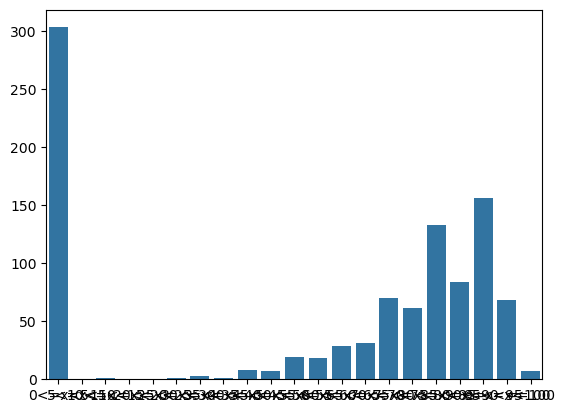

In [7]:
# visualize acc per class 

with open('/home/afroehli/coding/dinov2_ood/storage/acc_per_class.pkl', 'rb') as pkl_file:
    acc_per_class = pickle.load(pkl_file) 

acc_splitted = dict()

class_plus_acc = []
for inet_class in acc_per_class.keys():
    class_plus_acc.append((inet_class, acc_per_class[inet_class]['acc']))

class_plus_acc.sort(key = lambda tup: tup[1])
print(class_plus_acc)

min_i = 0
max_i = 0

for acc_min in range(0, 100, 5):
    acc_max = acc_min + 5 

    min_i = max_i 
    for n in range(min_i, len(class_plus_acc)):
        if acc_max / 100 <= class_plus_acc[n][1]:
            max_i = n 
            break 

    acc_splitted[f'{acc_min}<=x<{acc_max}'] = [inet_class for inet_class,_ in class_plus_acc[min_i:max_i]]

acc_splitted['==100'] = [inet_class for inet_class, _ in class_plus_acc[max_i:len(class_plus_acc)]]

for acc_split in acc_splitted.keys():
    print(f'{acc_split}: {len(acc_splitted[acc_split])}')

x_data = tuple(list(acc_splitted.keys()))
y_data = tuple([len(acc_splitted[inet_wnid]) for inet_wnid in acc_splitted.keys()])
sns.barplot(x=x_data, y=y_data)
plt.show()


In [13]:
# store classnames splitted per acc in csv

class_acc_df = pd.DataFrame()

for acc_intv in acc_splitted.keys():
    class_acc_df[acc_intv] = pd.Series([semantic_info.wnid_to_classname[wnid] for wnid in acc_splitted[acc_intv]])

class_acc_df.to_csv('/home/afroehli/coding/dinov2_ood/storage/acc_per_class_split.csv', sep=';')

In [10]:
test_model = LinearClassifier()
test_model.to(device)
test_model.eval()

imagenet_train_dataset = DictionaryDataset(datasets_dict['imagenet_x_train']['model_results'],
                                           imagenet_class_list)
imagenet_val_dataset = DictionaryDataset(datasets_dict['imagenet_x']['model_results'],
                                         imagenet_class_list)

train_loader = DataLoader(imagenet_train_dataset, batch_size=128, num_workers=8,
                          shuffle=True, pin_memory=True)
val_loader = DataLoader(imagenet_val_dataset, batch_size=128, 
                        shuffle=True, num_workers=8, pin_memory=True)

all_accuracies = []

for n in range(10):

    true_pred = 0
    total_pred = 0
    
    with torch.no_grad():
        for batch in (pbar := tqdm(val_loader, ncols=100)):

            samples, labels = batch[0].to(device), batch[1].to(device)

            model_out = test_model(samples)

            is_equal = labels.argmax(1) == model_out.argmax(1)
            true_pred += is_equal.type(torch.float).sum().item()

            total_pred += is_equal.size(0)

    last_accuracy = true_pred / total_pred
    print(f'Acc in epoch {n}: {last_accuracy}')
    all_accuracies.append(last_accuracy)

print(f'test accuracy: {sum(all_accuracies) / len(all_accuracies)}')

  0%|                                                                       | 0/391 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████| 391/391 [00:01<00:00, 253.91it/s]


Acc in epoch 0: 0.0011


100%|████████████████████████████████████████████████████████████| 391/391 [00:01<00:00, 250.80it/s]


Acc in epoch 1: 0.0011


100%|████████████████████████████████████████████████████████████| 391/391 [00:01<00:00, 251.72it/s]


Acc in epoch 2: 0.0011


100%|████████████████████████████████████████████████████████████| 391/391 [00:01<00:00, 260.43it/s]


Acc in epoch 3: 0.0011


100%|████████████████████████████████████████████████████████████| 391/391 [00:01<00:00, 252.09it/s]


Acc in epoch 4: 0.0011


100%|████████████████████████████████████████████████████████████| 391/391 [00:01<00:00, 266.76it/s]


Acc in epoch 5: 0.0011


100%|████████████████████████████████████████████████████████████| 391/391 [00:01<00:00, 265.81it/s]


Acc in epoch 6: 0.0011


100%|████████████████████████████████████████████████████████████| 391/391 [00:01<00:00, 254.25it/s]


Acc in epoch 7: 0.0011


100%|████████████████████████████████████████████████████████████| 391/391 [00:01<00:00, 256.60it/s]


Acc in epoch 8: 0.0011


100%|████████████████████████████████████████████████████████████| 391/391 [00:01<00:00, 248.50it/s]

Acc in epoch 9: 0.0011
test accuracy: 0.0011


In [15]:
epoch_to_load = 27

pretrained_head = torch.load('/home/afroehli/coding/dinov2_ood/storage/dinov2_vits14_linear_head.pth')
pretrained_torch_hub = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14_lc')
self_lin_classifier = torch.load(f'/home/afroehli/coding/dinov2_ood/storage/model_checkpoints/linear_classifier_epoch_{epoch_to_load}.pth', 
                        weights_only=False)
pretrained_head_model = LinearClassifier(in_features=768)
pretrained_head_copy = dict()
pretrained_head_copy['network.0.weight'] = pretrained_head['weight']
pretrained_head_copy['network.0.bias'] = pretrained_head['bias']
pretrained_head_model.load_state_dict(pretrained_head_copy)

print(f'downloaded model: {pretrained_torch_hub.embed_dim}')
print(pretrained_head.keys())
print(type(pretrained_torch_hub))
for name, val in pretrained_torch_hub.named_parameters():
    print(name, val.shape)
print(self_lin_classifier['model_state'].keys())
print(pretrained_head['weight'].size())
print(pretrained_head['weight'][0].size())
print(pretrained_head['weight'][1].size())

print(self_lin_classifier['model_state']['network.0.weight'].size())

pretrained_torch_hub.eval()
pretrained_head_model.eval()
test_in = datasets_dict['imagenet_x']['model_results']['n03680355'][0]
test_out = pretrained_head_model(torch.from_numpy(test_in))

/tmp/ipykernel_2417704/1417495845.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_head = torch.load('/home/afroehli/coding/dinov2_ood/storage/dinov2_vits14_li

AttributeError: '_LinearClassifierWrapper' object has no attribute 'embed_dim'

In [ ]:
imagenet_val_embeddings_data = DictionaryDataset(datasets_dict['imagenet_x']['model_results'], imagenet_class_list)
imagenet_train_embeddings_data = DictionaryDataset(datasets_dict['imagenet_x_train']['model_results'], imagenet_class_list)


imagenet_val_embeddings_loader = torch.utils.data.DataLoader(imagenet_val_embeddings_data, batch_size = 128, 
                                                      shuffle=False, num_workers=8, pin_memory=True)
imagenet_train_embeddings_loader = torch.utils.data.DataLoader(imagenet_train_embeddings_data, batch_size=128, 
                                                               shuffle=False, num_workers=8, pin_memory=True)

In [ ]:
# Check dimensions of result sets 

print(f'Number of calculated classes for Imagenet-X, Expected 1000, Acutal: {len(list(datasets_dict['imagenet_x']['model_results']))}')
print(f'Number of calculated classes for Imagenet-X-Train, Expected 135, Acutal: {len(list(datasets_dict['imagenet_x_train']['model_results']))}')
print(f'Number of calculated classes for Imagenet-V2, Expected 1000, Actual: {len(list(datasets_dict['imagenet_v2']['model_results']))}')
print(f'Number of calculated classes for Imagenet-C:, Expected  521, Actual: {len(list(datasets_dict['imagenet_c']['model_results']))}')
print(f'Number of calculated classes for Imagenet-R:, Expected  200, Actual: {len(list(datasets_dict['imagenet_r']['model_results']))}')

Number of calculated classes for Imagenet-X, Expected 1000, Acutal: 1000
Number of calculated classes for Imagenet-X-Train, Expected 135, Acutal: 135
Number of calculated classes for Imagenet-V2, Expected 1000, Actual: 1000
Number of calculated classes for Imagenet-C:, Expected  521, Actual: 521
Number of calculated classes for Imagenet-R:, Expected  200, Actual: 200


In [ ]:
# store complete datasets object

with open('/home/afroehli/coding/pickle_data/dinov2_ood_datasets_dict.pkl', 'wb') as pickle_file:
            pickle.dump(datasets_dict, pickle_file, pickle.HIGHEST_PROTOCOL)


In [13]:
## calculate statistics 

# general statistics on whole imagenet dataset 
# np-array with shape 1000 x 50 x 384
results_all_classes = np.array([datasets_dict['imagenet_x']['model_results'][class_wnid] for class_wnid in datasets_dict['imagenet_x']['model_results'].keys()])

mean_pictures_all_classes = np.mean(results_all_classes, axis=1)
mean_classes_all_classes = np.mean(mean_pictures_all_classes, axis=0)
mean_imagenet = mean_classes_all_classes # shape 384

statistics_dict = dict()

for inv_class, comp_class in closest_classes: 

    comb_key = (inv_class, comp_class)

    # select random compare class
    ran_comp_class = get_random_class()
    while ran_comp_class == inv_class or ran_comp_class == comp_class:
        ran_comp_class = get_random_class()

    statistics_dict[comb_key] = dict()
    statistics_dict[comb_key]['ran_comp_class'] = ran_comp_class 

    # statistics on invariant class
    inv_class_res = np.array(datasets_dict['imagenet_x']['model_results'][inv_class])
    inv_class_mean = np.mean(inv_class_res, axis=0)
    inv_class_std = np.std(inv_class_res, axis=0)

    # statistics on most similar compare class
    comp_class_res = np.array(datasets_dict['imagenet_x']['model_results'][comp_class])
    comp_class_mean = np.mean(comp_class_res, axis=0) 
    comp_class_std = np.std(comp_class_res, axis=0)
    diff_comp_inv = np.abs(comp_class_mean - inv_class_mean)

    diff_inet_mean_inv = np.abs(mean_imagenet - inv_class_mean)

    statistics_dict[comb_key] = dict()
    statistics_dict[comb_key]['counts-inet'] = dict()
    statistics_dict[comb_key]['counts'] = dict()
    statistics_dict[comb_key]['inSTD'] = dict()
    statistics_dict[comb_key]['sum'] = dict()

    # save statistics of compare class
    true_false_list = (diff_comp_inv < inv_class_std).tolist()
    comp_within_std = true_false_list.count(True)
    statistics_dict[comb_key]['inSTD']['comp'] = comp_within_std

    statistics_dict[comb_key]['sum']['comp'] = np.sum(diff_comp_inv)


    # calculate statistics for all other datasets and classes 
    for d_name, d_short, d_wnid in [('imagenet_x', 'inet', ''), ('imagenet_x', 'ranComp', ran_comp_class), 
                                    ('imagenet_r', 'inetR', inv_class), ('imagenet_v2', 'inetV2', inv_class), 
                                    ('imagenet_c', 'inetC', inv_class), ('imagenet_x', 'comp', comp_class),
                                    ('imagenet_c_new_zoom_sev_1', 'inetCNew1', inv_class), 
                                    ('imagenet_c_new_zoom_sev_5', 'inetCNew5', inv_class)]: 

        if d_short != 'inet':
            d_results = np.array(datasets_dict[d_name]['model_results'][d_wnid])
            d_result_mean = np.mean(d_results, axis = 0)
            # d_result_std = np.std(d_results, axis = 0)
        else: 
            d_result_mean = mean_classes_all_classes

        

        diff_to_inv = np.abs(d_result_mean - inv_class_mean)

        # count dimensions where mean of class1 is nearer than imagenet-mean 
        true_false_list = (diff_inet_mean_inv < diff_to_inv).tolist()
        inet_is_nearer = true_false_list.count(True)
        statistics_dict[comb_key]['counts-inet'][d_short] = inet_is_nearer 

        # count dimensions where mean of class1 is nearer than of class2 
        true_false_list = (diff_comp_inv < diff_to_inv).tolist()
        comp_is_nearer = true_false_list.count(True)
        statistics_dict[comb_key]['counts']['comp-' + d_short] = comp_is_nearer 

        # count dimensions where mean of class1 lies within std of inv-class
        true_false_list = (diff_to_inv < inv_class_std).tolist()
        counts_within_std = true_false_list.count(True)
        statistics_dict[comb_key]['inSTD'][d_short] = counts_within_std

        # sum of p1-distance over all dimensions
        statistics_dict[comb_key]['sum'][d_short] = np.sum(diff_to_inv)

# create dictionary holding all important statistic facts 
statistics_facts = dict()
all_combinations = statistics_dict.keys()
for measure in ['counts-inet', 'counts', 'inSTD', 'sum']: 
    statistics_facts[measure] = dict()

    for d_short in ['comp', 'inet', 'ranComp', 'inetR', 'inetV2', 'inetC']:


            if measure == 'counts':
                d_short = 'comp-' + d_short 

            measure_points_all_combs = np.array([statistics_dict[comb][measure][d_short] for comb in all_combinations])
            mean_measure_points = np.mean(measure_points_all_combs)
            std_measure_points = np.std(measure_points_all_combs)
            min_point = np.min(measure_points_all_combs)
            max_point = np.max(measure_points_all_combs)

            statistics_facts[measure][d_short] = dict()
            statistics_facts[measure][d_short]['mean'] = mean_measure_points 
            statistics_facts[measure][d_short]['std'] = std_measure_points 
            statistics_facts[measure][d_short]['min'] = min_point
            statistics_facts[measure][d_short]['max'] = max_point 



In [18]:
# prepare statistics 

all_combinations = list(statistics_dict.keys())
comb_mapping = dict()
for n, comb in enumerate(all_combinations):
    comb_mapping[n] = comb 

all_combinations_numbers = list(comb_mapping.keys())

# data for utilizing visualization

fifty_percent = [50 for i in range(0, len(all_combinations))]
fifty_percent_df = pd.DataFrame(data=list(zip(all_combinations_numbers, fifty_percent)), columns=['Comb', 'Val'])
fifty_percent_df['Rel'] = '50%'

# Smaller distance counts
# between ... and class-B
dfs_counts = []
all_count_types = ['comp-ranComp', 'comp-inet', 'comp-inetR', 'comp-inetV2', 'comp-inetC']
cov_shifted_count_types = ['comp-inet', 'comp-inetR', 'comp-inetV2', 'comp-inetC']
for count_type in all_count_types:
    relative_counts = [(statistics_dict[combination]['counts'][count_type] / 384) * 100 for combination in all_combinations]
    n_dim_nearer = [((384 / 2) - statistics_dict[combination]['counts'][count_type]) for combination in all_combinations]
    relative_counts_df = pd.DataFrame(data=list(zip(all_combinations_numbers, relative_counts, n_dim_nearer)), columns=['Comb', 'Val', 'Dim-Nearer'])
    relative_counts_df['Rel'] = count_type

    dfs_counts.append(relative_counts_df)

diff_counts_df = pd.concat(dfs_counts, ignore_index=True)

# between ... and Imagenet-Mean
dfs_inet_counts = []
inet_count_types = [('Class-B', 'comp'), ('Random-Class', 'ranComp'), ('Imagenet-R', 'inetR'), ('Imagenet-V2', 'inetV2'), ('Imagenet-C', 'inetC'),
                    ('Imagenet-C-New-1', 'inetCNew1'), ('Imagenet-C-New-5', 'inetCNew5')]
for label, count_type in inet_count_types:
    n_dim_nearer = [((384 / 2) - statistics_dict[combination]['counts-inet'][count_type]) for combination in all_combinations]
    inet_counts_df = pd.DataFrame(data=list(zip(all_combinations_numbers, n_dim_nearer)), columns=['Comb', 'Dim-Nearer'])
    inet_counts_df['Rel'] = label

    dfs_inet_counts.append(inet_counts_df)

diff_inet_counts_df = pd.concat(dfs_inet_counts, ignore_index=True)

# L1-Distance

# between ... and class-B
dfs_sums = []
all_sum_types = ['comp', 'ranComp', 'inet', 'inetR', 'inetV2', 'inetC']
cov_shifted_sum_types = ['inet', 'comp', 'inetR', 'inetV2', 'inetC']
for sum_type in all_sum_types:

    sum_diff = [statistics_dict[combination]['sum'][sum_type] for combination in all_combinations]
    mean_sum_diff = [sum(sum_diff) / 135 for i in range(0, 135)]
    diff_to_class_b = [(statistics_dict[combination]['sum']['comp'] - statistics_dict[combination]['sum'][sum_type]) for combination in all_combinations]
    
    sum_diff_df = pd.DataFrame(data = list(zip(all_combinations_numbers, sum_diff, mean_sum_diff, diff_to_class_b)), 
                                columns=['Comb', 'Sum', 'MeanSum', 'Diff-ClassB'])
    sum_diff_df['Rel'] = sum_type

    dfs_sums.append(sum_diff_df)
diff_sum_df = pd.concat(dfs_sums, ignore_index=True)

# between ... and Imagenet-Mean 
dfs_l1_inet = []
compared_classes = [('Random-Class', 'ranComp'), ('Class-B', 'comp'), ('Imagenet-R', 'inetR'), ('Imagenet-V2', 'inetV2'), ('Imagenet-C', 'inetC'),
                    ('Imagenet-C-New-1', 'inetCNew1'), ('Imagenet-C-New-5', 'inetCNew5')]
for label, compare_class in compared_classes: 

    diff_to_inet = [(statistics_dict[combination]['sum']['inet'] - statistics_dict[combination]['sum'][compare_class]) for combination in all_combinations]
    sum_diff_df = pd.DataFrame(data = list(zip(all_combinations_numbers, diff_to_inet)), 
                                columns=['Comb', 'L1-Diff-Inet'])
    sum_diff_df['Rel'] = label
    dfs_l1_inet.append(sum_diff_df)

diff_l1_inet_df = pd.concat(dfs_l1_inet, ignore_index=True)

# Dimension counts within std of classA

# between ... and class-B
dfs_within_std = []
all_dataset_types =  ['comp', 'ranComp', 'inet', 'inetR', 'inetV2', 'inetC']
cov_shifted_dataset_types = ['inet', 'comp', 'inetR', 'inetV2', 'inetC'] 
for d_type in all_dataset_types: 

    is_in_std = [statistics_dict[combination]['inSTD'][d_type] for combination in all_combinations]
    mean_is_in_std = [sum(is_in_std) / len(is_in_std) for i in range(0, 384)]
    diff_in_std_to_class_b = [statistics_dict[combination]['inSTD'][d_type] - statistics_dict[combination]['inSTD']['comp'] for combination in all_combinations]
    
    d_type_in_std_df = pd.DataFrame(data=list(zip(all_combinations_numbers, is_in_std, mean_is_in_std, diff_in_std_to_class_b)), 
                                    columns=['Comb','inSTD', 'meanInSTD', 'Diff-InSTD-ClassB'])
    d_type_in_std_df['Rel'] = d_type
    dfs_within_std.append(d_type_in_std_df)

within_std_df = pd.concat(dfs_within_std, ignore_index=True)

# between ... and Imagenet-Mean 
dfs_within_std_inet = []
compared_classes = [('Random-Class', 'ranComp'), ('Class-B', 'comp'), ('Imagenet-R', 'inetR'), ('Imagenet-V2', 'inetV2'), ('Imagenet-C', 'inetC'),
                    ('Imagenet-C-New-1', 'inetCNew1'), ('Imagenet-C-New-5', 'inetCNew5')]
for label, compare_class in compared_classes: 

    diff_in_std_to_inet = [statistics_dict[combination]['inSTD'][compare_class] - statistics_dict[combination]['inSTD']['inet'] for combination in all_combinations]
    diff_in_std_to_inet_df = pd.DataFrame(data = list(zip(all_combinations_numbers, diff_in_std_to_inet)), 
                                columns=['Comb', 'Diff-Counts-WithinSTD'])
    diff_in_std_to_inet_df['Rel'] = label
    dfs_within_std_inet.append(diff_in_std_to_inet_df)

within_std_inet_df = pd.concat(dfs_within_std_inet, ignore_index=True)

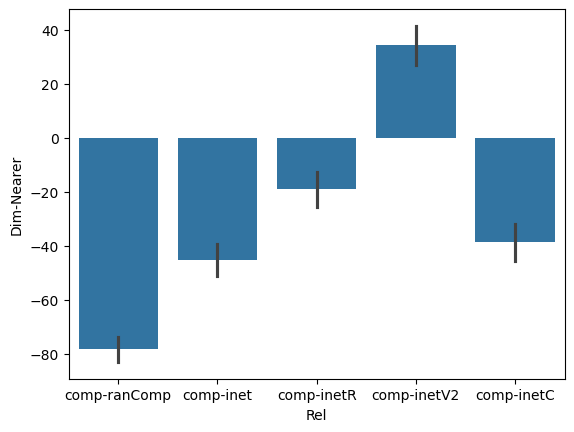

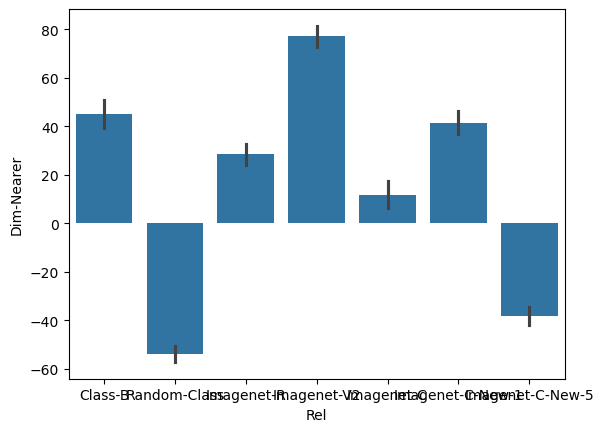

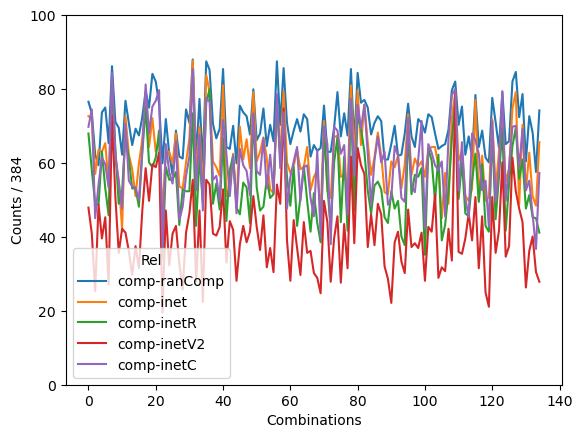

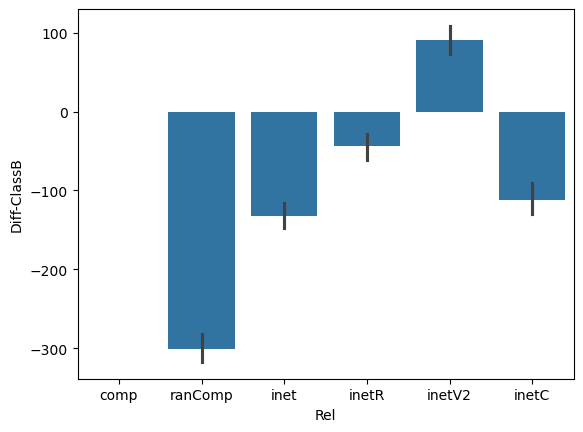

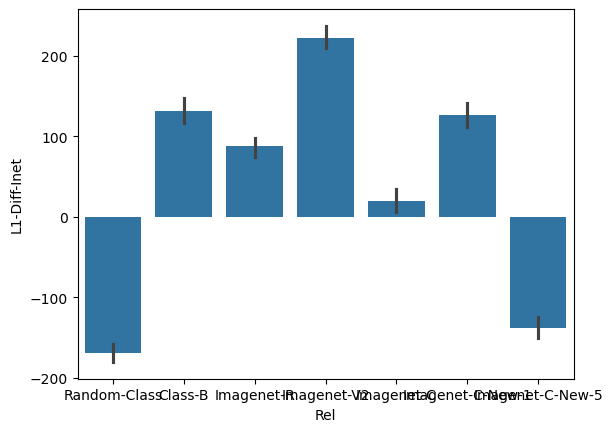

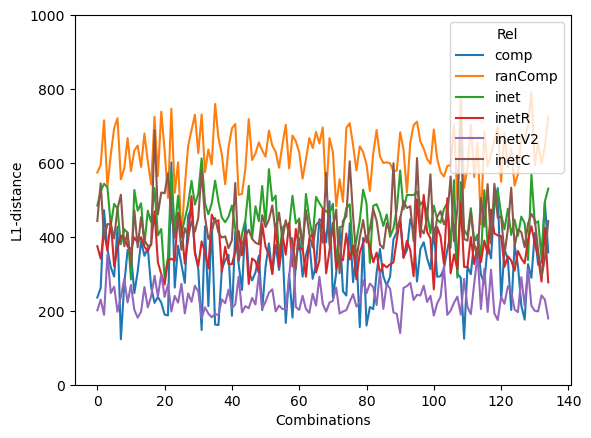

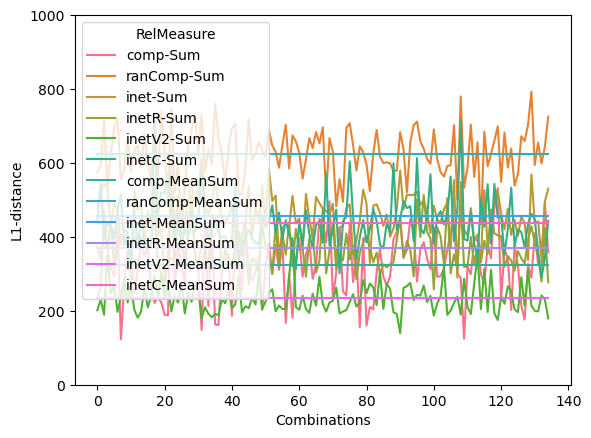

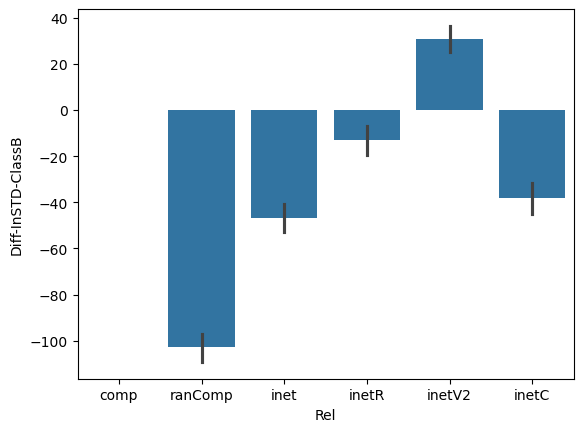

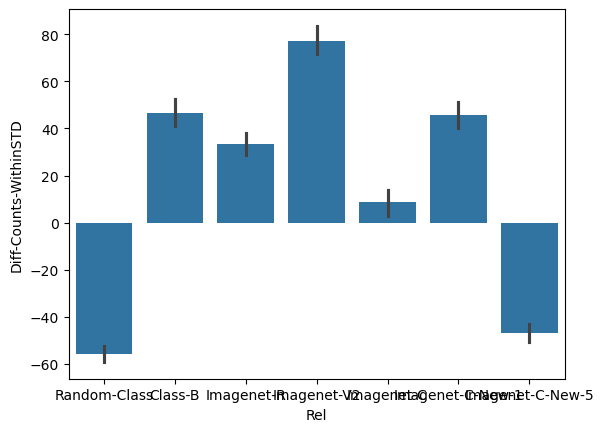

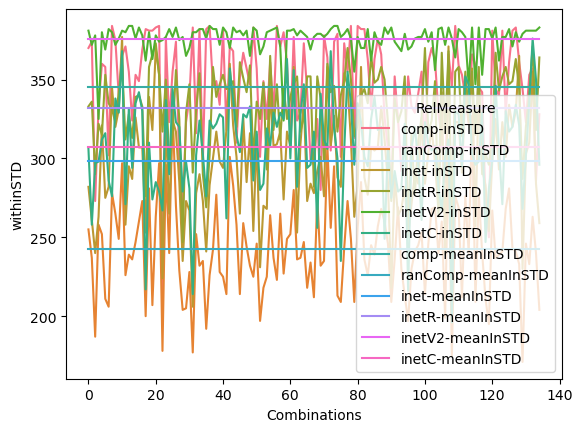

In [19]:
 # visualize statistics 

sns.barplot(data=diff_counts_df, x='Rel', y='Dim-Nearer')
plt.show()

sns.barplot(data=diff_inet_counts_df, x='Rel', y='Dim-Nearer')
plt.show()

plt.ylim(0,100)
ax = sns.lineplot(data=diff_counts_df, x='Comb', y='Val', hue='Rel')
ax.set(xlabel = 'Combinations', ylabel= 'Counts / 384')
plt.show()

sns.barplot(data=diff_sum_df, x='Rel', y='Diff-ClassB')
plt.show()

sns.barplot(data=diff_l1_inet_df, x='Rel', y='L1-Diff-Inet')
plt.show()

plt.ylim(0,1000)
ax = sns.lineplot(data=diff_sum_df, x='Comb', y='Sum', hue='Rel')
ax.set(xlabel='Combinations', ylabel='L1-distance')
plt.show()

sum_mean_combined = diff_sum_df.melt(id_vars=['Comb', 'Rel'], var_name='Measure', value_vars=['Sum', 'MeanSum'])
sum_mean_combined['RelMeasure'] = sum_mean_combined['Rel'] + '-' + sum_mean_combined['Measure']

plt.ylim(0,1000)
ax = sns.lineplot(data=sum_mean_combined, x='Comb', y='value', hue='RelMeasure', legend=True)
ax.set(xlabel='Combinations', ylabel='L1-distance')
plt.show()

sns.barplot(data=within_std_df, x='Rel', y='Diff-InSTD-ClassB')
plt.show()

sns.barplot(data=within_std_inet_df, x='Rel', y='Diff-Counts-WithinSTD')
plt.show()

in_std_with_mean = within_std_df.melt(id_vars=['Comb', 'Rel'], var_name = 'Measure', value_vars=['inSTD', 'meanInSTD'])
in_std_with_mean['RelMeasure'] = in_std_with_mean['Rel'] + '-' + in_std_with_mean['Measure']

ax = sns.lineplot(data=in_std_with_mean, x = 'Comb', y='value', hue='RelMeasure', legend=True)
ax.set(xlabel='Combinations', ylabel='withinSTD')
plt.show()

In [ ]:
# identify 50% of worst id-ood matches regarding mean distance 
# 

sum_combination_dict = dict()

for combination in all_combinations:
    sum_combination_dict[float(statistics_dict[combination]['id_sum'])] = combination 

sorted_dict = sorted(sum_combination_dict)
print(sorted_dict)

worst_id_ood_matches = []
for p, diff_sum in enumerate(sorted_dict):

    ood_wnid, id_wnid, ran_wnid = sum_combination_dict[diff_sum]
    id_name = semantic_info.wnid_to_classname[id_wnid]
    ood_name = semantic_info.wnid_to_classname[ood_wnid]

    print(f'{p}: Scored {diff_sum:.2e}: OOD = {ood_name}, ID = {id_name}')

print(f'Combinations printed: {len(sorted_dict)} from possible {len(all_combinations)} combinations.')

[285.52801513671875, 289.4336853027344, 292.9093017578125, 306.568359375, 309.7046203613281, 342.04351806640625, 364.65673828125, 364.68670654296875, 366.841552734375, 384.62213134765625, 399.7071838378906, 410.1962890625, 426.5854797363281, 427.532958984375, 434.56048583984375, 445.22161865234375, 470.74700927734375, 488.12548828125, 493.9937744140625, 502.389892578125, 508.62213134765625, 517.4906005859375, 528.6527099609375, 531.45068359375, 536.09912109375, 544.8900146484375, 554.5610961914062, 560.0919189453125, 565.3636474609375, 585.909912109375, 601.3419189453125, 618.6402587890625, 628.5443115234375, 641.086669921875, 641.65869140625, 643.666015625, 645.576904296875, 674.760986328125, 693.0130615234375, 693.08740234375]
0: Scored 2.86e+02: OOD =  Standard Poodle, ID =  Toy Poodle
1: Scored 2.89e+02: OOD =  cheetah, ID =  leopard
2: Scored 2.93e+02: OOD =  Whippet, ID =  Italian Greyhound
3: Scored 3.07e+02: OOD =  gorilla, ID =  orangutan
4: Scored 3.10e+02: OOD =  chimpanzee,

In [ ]:
# for each ood-class, find closest class in rest of imagenet-1k (999 candidates)

ood_class_comparisons = dict()
all_ood_wnids = [id_ood[0] for id_ood in class_splits]
imagenet_wnids = list(imagenet_x_val_results.keys())

print(f'Number of detected ood-wnids: {len(all_ood_wnids)}')
print(f'Number of detected imagenet-wnids: {len(imagenet_wnids)}')

for ood_wnid in all_ood_wnids:

    # calculate mean of model-output for this class 
    ood_mean = np.mean(imagenet_x_val_results[ood_wnid], axis=0)

    imagenet_wnids.remove(ood_wnid)
    for class_wnid in imagenet_wnids: 

        # calculate mean of selected class
        class_mean = np.mean(imagenet_x_val_results[class_wnid], axis=0)
        diff_ood = np.abs(ood_mean - class_mean)
        sum_class_diff = np.sum(diff_ood)
        try:
            ood_class_comparisons[ood_wnid].append((sum_class_diff, class_wnid))
        except KeyError:
            ood_class_comparisons[ood_wnid] = [(sum_class_diff, class_wnid)]

    # sort calculated mean differences
    ood_class_comparisons[ood_wnid].sort(key = lambda ood_id: ood_id[0])
    
    imagenet_wnids.append(ood_wnid)

Number of detected ood-wnids: 40
Number of detected imagenet-wnids: 1000
Total compare classes for n01616318: 999
Total compare classes for n02106550: 999
Total compare classes for n02096585: 999
Total compare classes for n02112137: 999
Total compare classes for n02091134: 999
Total compare classes for n02086240: 999
Total compare classes for n02056570: 999
Total compare classes for n02480855: 999
Total compare classes for n01534433: 999
Total compare classes for n02749479: 999
Total compare classes for n02108915: 999
Total compare classes for n02481823: 999
Total compare classes for n01694178: 999
Total compare classes for n02236044: 999
Total compare classes for n02423022: 999
Total compare classes for n02113799: 999
Total compare classes for n02814860: 999
Total compare classes for n01632777: 999
Total compare classes for n01986214: 999
Total compare classes for n02097298: 999
Total compare classes for n02098286: 999
Total compare classes for n02066245: 999
Total compare classes for

In [ ]:
# print closest compare classes for each ood-class

for ood_wnid in all_ood_wnids: 

    top_five = ood_class_comparisons[ood_wnid][:5]
    top_five_names = [(semantic_info.wnid_to_classname[wnid], score) for score, wnid in top_five]
    ood_name = semantic_info.wnid_to_classname[ood_wnid]
    print(f'OOD = {ood_name}: {top_five_names}')


OOD =  vulture: [(' bald eagle', np.float32(364.6867)), (' kite (bird of prey)', np.float32(374.1024)), (' hornbill', np.float32(427.8051)), (' ptarmigan', np.float32(438.59735)), (' black stork', np.float32(446.6934))]
OOD =  Rottweiler: [(' Black and Tan Coonhound', np.float32(247.84436)), (' Dobermann', np.float32(274.29382)), (' Miniature Pinscher', np.float32(354.40723)), (' Greater Swiss Mountain Dog', np.float32(369.6695)), (' Entlebucher Sennenhund', np.float32(377.0548))]
OOD =  Boston Terrier: [(' French Bulldog', np.float32(313.06226)), (' Staffordshire Bull Terrier', np.float32(401.3598)), (' Boxer', np.float32(438.5884)), (' American Staffordshire Terrier', np.float32(439.02612)), (' toy terrier', np.float32(443.41534))]
OOD =  Chow Chow: [(' Pomeranian', np.float32(366.84155)), (' Keeshond', np.float32(374.4064)), (' Samoyed', np.float32(429.12982)), (' Pekingese', np.float32(445.51138)), (' Great Pyrenees dog', np.float32(469.20425))]
OOD =  Whippet: [(' Ibizan Hound', n